<a href="https://colab.research.google.com/github/Samruddhi-saoji/AI-codes/blob/master/Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
from matplotlib import pyplot as plt

### Image handling

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

###### read an image ####
def read(img_path):
   return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)


##### save an image ###
def save(img, img_path="output.jpeg"):
   cv2.imwrite(img_path, img)


### get a list of all the images in a folder ####
# returns (list of images, list of names)
def list_images(folder_path):
    result = []

    # get list of names of all the images in the folder
    file_names = os.listdir(folder_path)

    # read each image as numpy aaray
    for img_name in file_names:
        # full path of the img = folder_path + image name
        image_path = os.path.join(folder_path, img_name)

        # Read the image and add it to the list
        img = read(image_path)
        if img is not None:
            result.append(read(image_path))

    return (result, file_names)


#delete all files in a folder
def delete_all_files(folder_path):
    files = glob.glob(os.path.join(folder_path, '*'))
    for file in files:
        if os.path.isfile(file):
            os.remove(file)


# Display image
def display(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Remove axes
    plt.show()

#compress image
  # reduce img from size (r1, c1) to (r2, c2)
  # every (r1/r2)th row and every (c1/c2)th vol of the original img shld be copied to the compressed img
def compress_img(img, r1, c1, r2, c2):
    compressed_img = img[::r1 // r2, ::c1 // c2]
    return compressed_img


# (h_old, w_old) to (h_new, w_new)
def crop(img, r_start, num_rows, c_start, num_cols):
    cropped_img = img[r_start:r_start + num_rows, c_start: c_start + num_cols :]
    return cropped_img


#create a composite image from a list of images
# images = list of images
def get_composite(images):
    # Ensure all images have the same shape
    image_shape = images[0].shape
    for img in images:
        if img.shape != image_shape:
            raise ValueError("All images must have the same shape")

    # Initialize an array to store the composite image
    composite_image = np.zeros_like(images[0], dtype=np.float32)

    # Sum the pixel values from all images
    for img in images:
        composite_image += img.astype(np.float32)

    # Normalize the composite image to the range [0, 255]
    # only sum, not average
    np.clip(composite_image, 0, 255)
    # take average
    #composite_image = (composite_image / len(images)).astype(np.uint8)

    return composite_image

# Pre-trained model (SSD)

## Load the SSD model

In [ ]:
# Load the pre-trained SSD model from TensorFlow Hub
model_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
model = hub.load(model_url)

## Helper functions

In [ ]:
# Function to load and preprocess image
def preprocess_image(bgr_image, target_width=300, target_height=300):
    #convert to rgb
    img = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # resize
    img = tf.image.resize(img, (target_width, target_height))

    # convert to datatype uint8
    img = tf.cast(img, dtype=tf.uint8)

    # add extra dimension for batch
    img = tf.expand_dims(img, axis=0)
    return img



#function to perform non max suppression
  # object = bbox, class, confidence score
def non_max_suppression(bboxes, classes, confidences, conf_thresh=0.25, iou_thresh=0.5):
   # Convert to a tensor
   bboxes_tensor = tf.convert_to_tensor(bboxes)
   conf_tensor = tf.convert_to_tensor(confidences)

   # Apply Non-Maximum Suppression (NMS)
   selected_indices = tf.image.non_max_suppression(
        bboxes_tensor, conf_tensor, max_output_size=len(bboxes), iou_threshold=iou_thresh, score_threshold=conf_thresh
   )

   # get the final objects (bb, class, confidence)
   bboxes = tf.gather(bboxes_tensor, selected_indices).numpy()
   confidences = tf.gather(conf_tensor, selected_indices).numpy()
   classes = tf.gather(classes, selected_indices).numpy()

   return bboxes, classes, confidences



# Function to draw bounding boxes
def draw_bounding_boxes(image, boxes, classes, scores, threshold=0.25, iou_threshold=0.5):
    h, w, _= image.shape
    n = len(scores) # no of objects

    # For each object
    for i in range(n):
        # bounding box coordinates
        y1, x1, y2, x2 = boxes[i]

        # draw the bounding box
        start_point = (int(x1 * w), int(y1 * h))
        end_point = (int(x2 * w), int(y2 * h))
        cv2.rectangle(image, start_point, end_point, (0, 255, 0), 2)

        # get the class
        class_id = int(classes[i])
        class_name = get_class_name(class_id)

        # label the object (class, confidence
        label = f"Class {class_name}, Score: {scores[i]:.2f}"
        cv2.putText(image, label, (start_point[0], start_point[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return image



# Function to get class name from class ID
def get_class_name(class_id, label_map_path='coco_labels.txt'):
    # Initialize a list to store class names
    category_index = []

    # Read the class names from the label map text file
    with open(label_map_path, 'r') as file:
        lines = file.readlines()
        category_index = [line.strip() for line in lines]  # Strip whitespace and store in list

    # Return the class name based on class_id, or 'Unknown' if not found
    # Subtract 1 from class_id as Python lists are 0-indexed
    return category_index[class_id - 1] if 0 <= class_id - 1 < len(category_index) else 'Unknown'

## main code

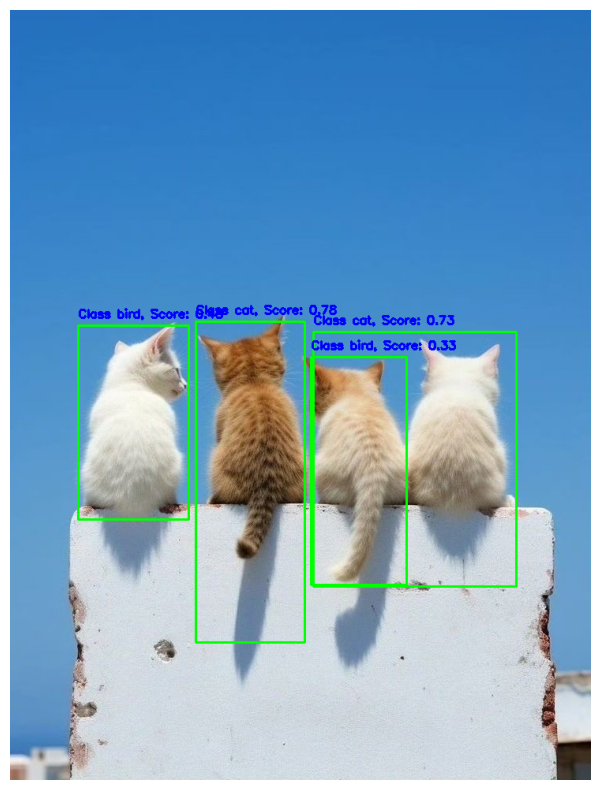

In [ ]:
# read and preprocess the image
image_path = "/content/sample.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
processed_image = preprocess_image(image, 300, 300)


# Perform object detection
detections = model(processed_image)

# Extract detection results
detected_boxes = detections["detection_boxes"].numpy()[0]
detected_scores = detections["detection_scores"].numpy()[0]
detected_classes = detections["detection_classes"].numpy()[0]

# post processing: Non Max suppression
bboxes, classes, scores = non_max_suppression(detection_boxes, detection_classes, detection_scores)
num_obj = len(bboxes) # no of obj in the img

# Draw bounding boxes on the original image
output_image = draw_bounding_boxes(image, bboxes, classes, scores)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()